# 00 – Data Overview

In this notebook, we will load and inspect the parquet datasets to understand their structure, content, and any potential issues that may need to be addressed during preprocessing.

There are five parquet files provided:
### 1. Earnings call transcripts
  - File: `data/transcripts.parquet`  
  - Earnings-call transcripts
  - Columns (sample): `symbol`, `year`, `quarter`, `full_transcript`

### 2. EC mapping
  - File: `data/ec_mapping.parquet` 
  - Lookup table mapping each `symbol`/`year`/`quarter` trio to the corresponding earnings-call date `rdq` for event alignment.
  - Use to align transcripts with dates.

### 3. Daily prices (NYSE/NASDAQ)
  - File: `data/algoseek_nyse_nasdaq.parquet`  
  - Contains daily OHLCV and adjusted columns per `Ticker`, `Date`.  
  - **Instruction:** use **Adjusted Close** (`CloseAdjusted`) for return computations.

### 4. Additional quarterly fundamentals
  - File: `data/additional_ec_data.parquet`  
  - Quarterly fundamentals keyed by ticker (`tic`) and event-date (`rdq_x`) supplying firm-level controls like sales, earnings, and balance-sheet items.
  - Join keys: `rdq_x` (**EC date**) and `tic` (**Ticker**).  
  - Includes ~681 variables; column descriptions provided in the attached Docx (see `var_descriptions.parquet` below).

### 5. Variable descriptions (Docx converted)
  - File: `data/var_descriptions.parquet`  
  - Documents variable names, types, and descriptions for the additional fundamentals.

Each dataset will be loaded and inspected below.

## Shared Helpers
Utilities for loading Parquet files, computing quick summaries, and printing previews.

In [19]:
from __future__ import annotations

import json
import gc
import logging
from pathlib import Path
from typing import Optional
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

DATASETS_DIR = Path('data')
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

def load_parquet(path: Path, sample_size: Optional[int] = None) -> pd.DataFrame:
    try:
        import pyarrow.parquet as pq
        table = pq.read_table(path)
        df = table.to_pandas()
    except Exception as exc:
        logging.warning('Falling back to pandas.read_parquet for %s (%s)', path, exc)
        df = pd.read_parquet(path)
    if sample_size is not None:
        df = df.head(sample_size)
    return df

def summarise(df: pd.DataFrame) -> dict:
    summary = {
        'shape': df.shape,
        'columns': df.columns.tolist(),
        'dtypes': df.dtypes.astype(str).to_dict(),
        # only show columns with missing values in the dictionary
        # if no missing values, say 'None'
        'missing_counts': {col: int(df[col].isna().sum()) for col in df.columns if df[col].isna().sum() > 0} or 'None',
        'duplicate_rows': int(df.duplicated().sum()),
    }
    return summary

def display_summary(name: str, df: pd.DataFrame) -> None:
    summary = summarise(df)
    print('### {}'.format(name))
    print('Rows: {}  |  Columns: {}'.format(summary['shape'][0], summary['shape'][1]))
    print('Duplicate rows: {}'.format(summary['duplicate_rows']))
    print('Missing values:', summary['missing_counts'])
    print('Columns:', ', '.join(summary['columns']))

def describe_numeric(df: pd.DataFrame) -> pd.DataFrame:
    numeric = df.select_dtypes(include=['number'])
    if numeric.empty:
        return pd.DataFrame()
    return numeric.describe().T

def preview(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    return df.head(n)

def save_summary(name: str, df: pd.DataFrame) -> None:
    path = OUTPUT_DIR / '{}_summary.json'.format(name)
    path.write_text(json.dumps(summarise(df), indent=2))
    logging.info('Saved summary to %s', path)


In [20]:
matplotlib_dark_theme = True

if matplotlib_dark_theme:
	plt.rcParams.update({
		# Fonts and text
		"text.color": "white",
		"axes.labelcolor": "white",
		"xtick.color": "white",
		"ytick.color": "white",

		# Axes/spines
		"axes.edgecolor": "white",  # borders
		"xtick.color": "white",
		"ytick.color": "white",
		"grid.color": "white",

		# Background
		"figure.facecolor": "none",  # transparent
		"axes.facecolor": "none"
	})

---
## 1. Earnings Call Transcripts (`transcripts.parquet`)

In [21]:
transcripts_path = DATASETS_DIR / 'transcripts.parquet'
transcripts_df = load_parquet(transcripts_path)
display_summary('Transcripts', transcripts_df)
preview(transcripts_df)


KeyboardInterrupt: 

In [ ]:
lengths = transcripts_df['full_transcript'].dropna().astype(str).str.len()
lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

In [ ]:
#Sampling every 10th transcript to confirm the majority language is English before applying the model.

try:
    from langdetect import detect
except ImportError:
    logging.warning('langdetect not installed – install via pip if you need the language audit.')
else:
    sample_text = transcripts_df['full_transcript'].dropna().astype(str).iloc[::10]
    languages = sample_text.apply(lambda txt: detect(txt[:500]))
    languages.value_counts()
    print(f"Languages detected in sample: {languages.value_counts().to_dict()}")

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
lengths.hist(ax=ax, bins=40, color='steelblue', edgecolor='white')
ax.set_title('Transcript length (characters)')
ax.set_xlabel('Characters')
ax.set_ylabel('Count')
plt.tight_layout()


In [ ]:
# clean up the variable to save memory
del transcripts_df
del lengths

gc.collect()

---
## 2. EC Mapping (`ec_mapping.parquet`)

In [ ]:
mapping_path = DATASETS_DIR / 'ec_mapping.parquet'
mapping_df = load_parquet(mapping_path)
display_summary('EC Mapping', mapping_df)
preview(mapping_df)

In [ ]:
# Clean up up the variable to save memory
del mapping_df
gc.collect()

---
## 3. Daily Prices (`algoseek_nyse_nasdaq.parquet`)

In [ ]:
prices_path = DATASETS_DIR / 'algoseek_nyse_nasdaq.parquet'
prices_df = load_parquet(prices_path, sample_size=10000)
display_summary('Daily Prices (sample)', prices_df)
preview(prices_df)

In [ ]:
describe_numeric(prices_df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna(how='all'))

In [ ]:
# Clean up
del prices_df
gc.collect()

---
## 4. Additional EC Data (`additional_ec_data.parquet`)

In [5]:
additional_path = DATASETS_DIR / 'additional_ec_data.parquet'
additional_df = load_parquet(additional_path)
display_summary('Additional EC Data (sample)', additional_df)
preview(additional_df)

### Additional EC Data (sample)
Rows: 67994  |  Columns: 681
Duplicate rows: 0
Missing values: {'acctchgq': 65224, 'adrrq': 67923, 'bsprq': 52955, 'compstq': 62191, 'curncdq': 15, 'currtrq': 15, 'curuscnq': 67734, 'datacqtr': 20, 'datafqtr': 8, 'finalq': 10, 'ogmq': 66691, 'scfq': 31, 'staltq': 67976, 'apdedateq': 2, 'fdateq': 12, 'pdateq': 8595, 'acchgq': 2356, 'acomincq': 206, 'acoq': 3659, 'actq': 14018, 'altoq': 6188, 'ancq': 16502, 'anoq': 15735, 'aociderglq': 3655, 'aociotherq': 1843, 'aocipenq': 2875, 'aocisecglq': 1886, 'aol2q': 15808, 'aoq': 3, 'apq': 919, 'aqaq': 49423, 'aqdq': 49929, 'aqepsq': 50561, 'aqpl1q': 15779, 'aqpq': 43873, 'arcedq': 67994, 'arceepsq': 67994, 'arceq': 67994, 'atq': 2, 'aul3q': 15762, 'billexceq': 56586, 'capr1q': 64370, 'capr2q': 64370, 'capr3q': 64368, 'capsftq': 62138, 'capsq': 759, 'ceiexbillq': 59392, 'ceqq': 2, 'cheq': 3, 'chq': 3657, 'cibegniq': 256, 'cicurrq': 1758, 'ciderglq': 1575, 'cimiiq': 245, 'ciotherq': 365, 'cipenq': 1047, 'ciq': 228, 

,rdq_x,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,2010-04-29,6104,2010-03-31,2010,1.0,12,INDL,C,D,STD,...,1.0,2631,400.0,970.0,B+,TN,0.0,www.internationalpaper.com,None,None
1,2010-07-28,6104,2010-06-30,2010,2.0,12,INDL,C,D,STD,...,1.0,2631,400.0,970.0,B+,TN,0.0,www.internationalpaper.com,None,None
2,2010-10-27,6104,2010-09-30,2010,3.0,12,INDL,C,D,STD,...,1.0,2631,400.0,970.0,B+,TN,0.0,www.internationalpaper.com,None,None
3,2011-02-03,6104,2010-12-31,2010,4.0,12,INDL,C,D,STD,...,1.0,2631,400.0,970.0,B+,TN,0.0,www.internationalpaper.com,None,None
4,2011-04-28,6104,2011-03-31,2011,1.0,12,INDL,C,D,STD,...,1.0,2631,400.0,970.0,B+,TN,0.0,www.internationalpaper.com,None,None


In [4]:
describe_numeric(additional_df.select_dtypes(include=['number']).iloc[:, :10])

,count,mean,std,min,25%,50%,75%,max
gvkey,5000.0,56805.639400,65605.988068,1045.000000,8001.000000,24861.00000,115876.000000,285085.0000
fyearq,5000.0,2017.591200,3.765703,2010.000000,2015.000000,2018.00000,2021.000000,2024.0000
fqtr,5000.0,2.505400,1.117775,1.000000,2.000000,3.00000,4.000000,4.0000
fyr,5000.0,10.473600,3.323900,1.000000,12.000000,12.00000,12.000000,12.0000
adrrq,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ajexq,5000.0,1.214390,1.771758,0.066667,1.000000,1.00000,1.000000,20.0000
ajpq,5000.0,1.214576,1.771686,0.066667,1.000000,1.00000,1.000000,20.0000
currtrq,5000.0,1.000023,0.001643,1.000000,1.000000,1.00000,1.000000,1.1162
curuscnq,14.0,0.800736,0.069226,0.722600,0.751225,0.77465,0.846925,0.9367
scfq,5000.0,7.000000,0.000000,7.000000,7.000000,7.00000,7.000000,7.0000


Total rows in dataset: 67994
Max missing values in a column: 67994


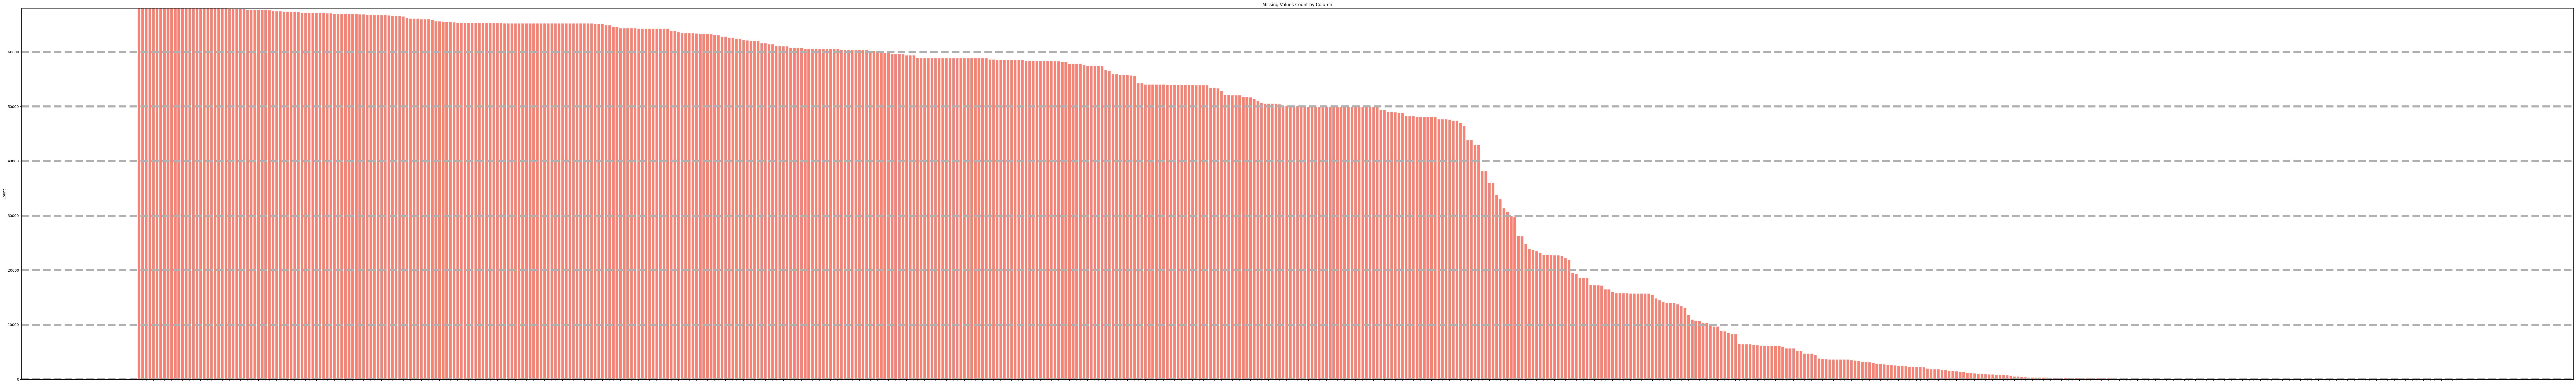

Columns sorted by missing values count: ['arcedq', 'arceepsq', 'arceq', 'gdwlamq', 'arcedy', 'arceepsy', 'arcey', 'fopty', 'fsrcty', 'fusety', 'gdwlamy', 'tsafcy', 'ufretsdy', 'unwccy', 'ustdncy', 'utfdocy', 'utfoscy', 'uwkcapcy', 'wcapchy', 'wcapcy', 'add3', 'add4', 'county', 'fsrcoy', 'fuseoy', 'staltq', 'dlrsn', 'dldte', 'add2', 'adrrq', 'utemq', 'utmey', 'ucconsq', 'curuscnq', 'amcy', 'finlcoq', 'finivstq', 'finltoq', 'prirow', 'finacoq', 'findlcq', 'finnpq', 'itccy', 'finchq', 'finaoq', 'dvintfq', 'finrecltq', 'findltq', 'finxintq', 'finxinty', 'finxoprq', 'finxopry', 'prican', 'nimy', 'finreccq', 'rrdq', 'rrepsq', 'rraq', 'rrdy', 'rrepsy', 'rray', 'rrpq', 'rrpy', 'afudccy', 'afudciy', 'finrevq', 'finrevy', 'uddq', 'udpcoq', 'udmbq', 'ogmq', 'udoltq', 'udfccy', 'ivaeqq', 'intaccq', 'esubq', 'esuby', 'pdvcy', 'rra12', 'rrd12', 'rreps12', 'upmcstkq', 'usubdvpq', 'usubdvpy', 'upmsubpq', 'ivaoq', 'prstkccy', 'uaptq', 'tdcy', 'uinvq', 'gdwliepsy', 'gdwliepsq', 'usubpcvq', 'scstkcy', 'u

In [18]:
# display a bar plot of the missing values counts for all columns sorted by counts
missing_counts = {col: int(additional_df[col].isna().sum()) for col in additional_df.columns if additional_df[col].isna().sum() > 0}
if missing_counts:
    sorted_missing = dict(sorted(missing_counts.items(), key=lambda item: item[1], reverse=True))
    fig, ax = plt.subplots(figsize=(100, 15))
    ax.bar(range(len(sorted_missing)), list(sorted_missing.values()), color='salmon', edgecolor='white')
    ax.set_title('Missing Values Count by Column')
    # height of chart is set to the number of rows
    ax.set_ylim(0, additional_df.shape[0])
    print(f"Total rows in dataset: {additional_df.shape[0]}")
    print(f"Max missing values in a column: {max(sorted_missing.values())}")
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(sorted_missing)))
    ax.set_xticklabels([''] * len(sorted_missing))  # No labels
    plt.tight_layout()
    # set grid lines for every 5000 keys
    ax.set_yticks(range(0, additional_df.shape[0], 10000))
	# make grid lines thicker
    ax.yaxis.grid(True, linestyle='--', linewidth=5.7)
    plt.show()
    print("Columns sorted by missing values count:", list(sorted_missing.keys()))

In [ ]:
# Clean up
del additional_df
gc.collect()

---
## 5. Variable Descriptions (`var_descriptions.parquet`)

In [ ]:
var_desc_path = DATASETS_DIR / 'var_descriptions.parquet'
var_desc_df = load_parquet(var_desc_path)
display_summary('Variable Descriptions', var_desc_df)
preview(var_desc_df)


In [ ]:
# Clean up up the variable to save memory
del var_desc_df
gc.collect()